In [2]:
pwd

'c:\\Users\\Meeth\\CelesDataAnal'

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize

START

In [4]:
# Config Data
G = 1.9935608097491742e-38

ELLIPSE SETUP

In [5]:
# given phase input, return conic parameters
def retConicParam(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    print(a, np.linalg.norm(r))
    TP = 2*math.pi*math.sqrt(math.pow(a,3)/mu)
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    n = math.sqrt(mu/math.pow(a,3))
    E = math.acos((a - np.linalg.norm(r))/(a*ecc))
    M = E - ecc*math.sin(E)
    return {'a':a, 'ecc':ecc, 'TP':TP, 'n': n, 'E': E, 'M': M, 'mu': mu}

Newton Optimiser Step

In [6]:
def f(M, ecc):
    return lambda x: x - ecc * math.sin(x) - M

def fPrime(ecc):
    return lambda x: 1 - ecc * math.cos(x)

In [7]:
def conicPts(n, ecc, M,E, step):
    M1 = M + n*step
    E1 = optimize.newton(f(M1, ecc), E, fPrime(ecc))
    return E1

In [8]:
# return position of object given conic parameters and iterated vaue of E
def retPos(a, ecc, E, mu):
    r = a * (1 - ecc * math.cos(E))
    theta = 2*math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    return np.array([r*math.cos(theta), r*math.sin(theta)])

In [9]:
# returns all the points broken into N pieces
def getPts(parameters, r, N):
    step = parameters['TP']/N
    n = parameters['n']
    ecc = parameters['ecc']
    M = parameters['M']
    E = parameters['E']
    a = parameters['a']
    pnt = [np.copy(r)]
    print(pnt)
    mu = parameters['mu']
    for i in range(math.floor(N*3/4)):
        # M1 = M + n*step
        E1 = conicPts(n, ecc, M, E, step)
        r1 = retPos(a, ecc, E1, mu)
        E = E1
        M = E - ecc*math.sin(E)
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt
        

    

Execution

In [23]:
op = {'M': 9e30, 'r': np.array([131.06729782512122,56.38166198901782]), 'v': np.array([-0.000012407253447004347, 0.0000382618120571045])}
parameters = retConicParam(op)
parameters

199.9999999999999 142.67981065246366


{'a': 199.9999999999999,
 'ecc': 0.29999999999999993,
 'TP': 41955496.35407392,
 'n': 1.4975833569347065e-07,
 'E': 0.30000000000000465,
 'M': 0.21134393800160145,
 'mu': 1.7942047287742567e-07}

In [11]:
fpnts = getPts(parameters, op['r'], 5000)

[array([131.06729783,  56.38166199])]


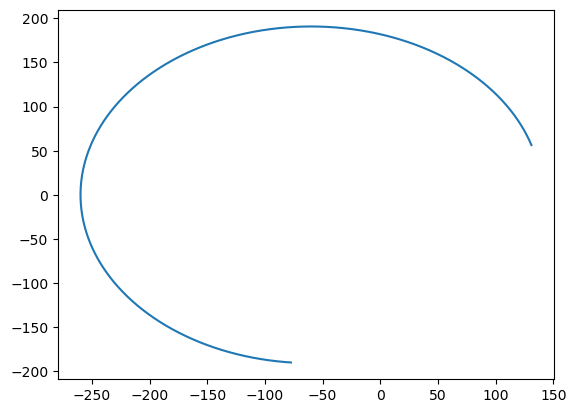

In [12]:
df = pd.DataFrame(columns=['x', 'y'])
df['x'] = fpnts[:, 0]
df['y'] = fpnts[:, 1]
plt.plot(df['x'], df['y']) 

In [13]:
# given phase input, return conic parameters
def retConicParamH(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    n = math.sqrt(mu/math.pow(-a,3))
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    F = math.acosh((1 - np.linalg.norm(r)/a)/ecc) 
    M = ecc*math.sinh(F) - F 
    return {'a':a, 'ecc':ecc, 'n':n, 'F': F, 'M': M, 'mu': mu}

In [14]:
def fH(M, ecc):
    return lambda x: ecc * math.sinh(x) - x - M

def fHPrime(ecc):
    return lambda x: ecc * math.cosh(x) - 1

In [15]:
def conicPtsH(n, ecc, M,F, step):
    M1 = M + n*step
    F1 = optimize.newton(fH(M1, ecc), F, fHPrime(ecc))
    return F1

In [78]:
# return position of object given conic parameters and iterated vaue of E
def retPosH(a, ecc, F, mu):
    r = -1 * a * ( ecc * math.cosh(F) - 1)
    theta = 2*math.atan(math.sqrt((1+ecc)/(ecc - 1)) * math.tan(F/2))
    print(r, theta)
    return np.array([r*math.cos(theta), r*math.sin(theta)])

In [79]:
# returns all the points broken into N pieces
def getPtsH(parameters, r, N):
    n = parameters['n']
    step = math.pi*2/(n*N) 
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    pnt = [np.copy(r)]
    print(pnt)
    mu = parameters['mu']
    print(step)
    for i in range(math.floor(10)):
        F1 = conicPtsH(n, ecc, M, F, step)
        r1 = retPosH(a, ecc, F1, mu)
        # if(i < 4):
        #     print(r1, M)
        F = F1
        M = ecc*math.sinh(F) - F
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
        # if i < 5:
        #     print(pnt,i)
    return pnt

In [80]:
# opH = {'M': 9e30, 'r': np.array([140,0]), 'v': np.array([0, 0.000051])}
opH = {'M': 9e30, 'r': np.array([131.06729782512122,56.38166198901782]), 'v': np.array([-0.000012407253447004347, 0.0000682618120571045])}
parametersH = retConicParamH(opH)
parametersH

{'a': -78.05619790960063,
 'ecc': 2.7648461856265287,
 'n': 6.142213508217152e-07,
 'F': 0.21318282961442647,
 'M': 0.380709596290588,
 'mu': 1.7942047287742567e-07}

In [76]:
-1 * -78.05619790960063 * ( 2.7648461856265287 * math.cosh(0.21318282961442647) - 1)

142.67981065246366

In [77]:
np.linalg.norm([131.06729782512122,56.38166198901782])

142.67981065246366

In [82]:
2*math.atan(math.sqrt((1+2.7648461856265287)/(2.7648461856265287 - 1)) * math.tan(0.21318282961442647/2))

0.3100437398525267

In [87]:
142.67981065246366 * math.cos(0.3100437398525267)

135.87686949122875

In [81]:
fpntsH = getPtsH(parametersH, opH['r'], 5000)

[array([131.06729783,  56.38166199])]
2045.9026045818302
142.71172835121803 0.3110349676102004
142.74374318181083 0.3120258924985217
142.7758550706354 0.31301651375501266
142.80806394393232 0.31400683061921014
142.84036972778935 0.3149968423326681
142.87277234814283 0.31598654813896
142.90527173077817 0.316975947283681
142.93786780133038 0.3179650390144504
142.97056048528512 0.3189538225809135
143.0033497079792 0.31994229723474404


In [73]:
86826799/(3600*24)

1004.9398032407407

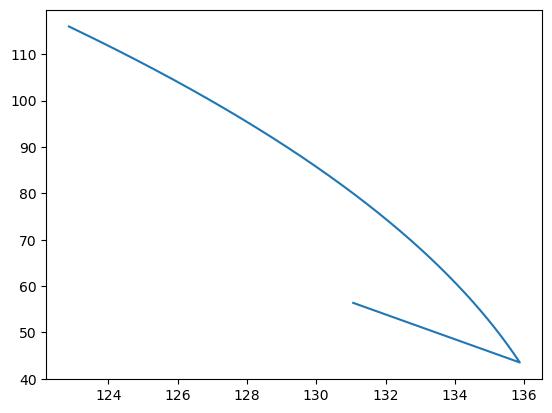

In [74]:
dfH = pd.DataFrame(columns=['x', 'y'])
dfH['x'] = fpntsH[:, 0]
dfH['y'] = fpntsH[:, 1]
plt.plot(dfH['x'], dfH['y'])

In [85]:
   mb

NameError: name 'mb' is not defined